In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score
from tensorflow.keras.utils import to_categorical

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


Dataset
--------

In [ ]:
test=pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\UBION_Credit-main\Code\1108_newborn2_minmax_test.csv')
train=pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\UBION_Credit-main\Code\1108_newborn2_minmax_train.csv')
submission=pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\sample_submission.csv')

In [64]:
# train=pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\final_set_train.csv')
# test=pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\final_set_test.csv')
# submission=pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\sample_submission.csv')

In [65]:
train

,Unnamed: 0,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,...,family_size,begin_month,credit,age_year,age_total,work_year,work_total,ID,Nth_card,income_mean
0,0,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,...,2.0,-24.0,0.0,57.0,57.42,0.0,0.00,0.0,3,51750.0
1,1,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,...,2.0,-28.0,0.0,57.0,57.08,0.0,0.00,0.0,2,51750.0
2,2,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,0,...,2.0,-30.0,2.0,56.0,57.00,0.0,0.00,0.0,1,51750.0
3,3,F,N,N,103500.0,Pensioner,Higher education,Single / not married,House / apartment,0,...,1.0,-17.0,2.0,65.0,65.83,0.0,0.00,1.0,2,103500.0
4,4,F,N,N,103500.0,Pensioner,Higher education,Single / not married,House / apartment,0,...,1.0,-39.0,2.0,64.0,64.00,0.0,0.00,1.0,1,103500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,M,Y,Y,292500.0,Working,Secondary / secondary special,Married,House / apartment,0,...,6.0,-24.0,2.0,36.0,36.75,0.0,0.00,8757.0,1,48750.0
26453,26453,M,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,0,...,2.0,-19.0,1.0,29.0,29.58,5.0,5.92,8758.0,4,101250.0
26454,26454,M,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,0,...,2.0,-21.0,1.0,29.0,29.42,5.0,5.75,8758.0,3,101250.0
26455,26455,M,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,0,...,2.0,-46.0,0.0,27.0,27.33,3.0,3.67,8758.0,2,101250.0


In [66]:
datalist = [train, test]
col = ['Unnamed: 0','begin_month','age_year','work_year']
# 로그스케일링 후 income_total, income_mean 고려하여 drop

for dataset in datalist:
    dataset.drop(columns=col, inplace=True)

In [67]:
train['ID'] = train['ID'].astype('object')
test['ID'] = test['ID'].astype('object')

In [68]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  10
Number of Categorical features:  9


In [69]:
numerical_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'age_total',
 'work_total',
 'Nth_card',
 'income_mean']

In [70]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

Log Scale
------

In [71]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])
    df['income_mean'] = np.log1p(1+df['income_mean'])

OrdinalEncoder
-----

In [72]:
encoder = OrdinalEncoder()
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])


StandardScale
----
- 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [73]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

Modeling-RandomForest
----

In [74]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [75]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 19) (26457, 1) (10000, 19)


In [76]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 0)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 19)
(19842, 1)
Validation set: 
(6615, 19)
(6615, 1)
log_loss: 0.7664619375466183


In [77]:
def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:0.7638112278327701
FOLD 1 : logloss:0.804660237889299
FOLD 2 : logloss:0.7756428677525248
FOLD 3 : logloss:0.7765930279586051
FOLD 4 : logloss:0.7575549818787136
Mean:0.7756524686623826


<AxesSubplot:>

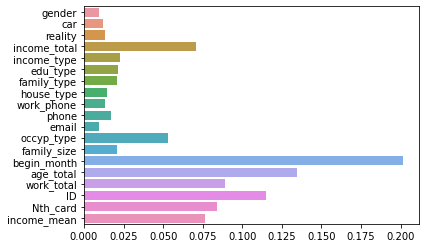

In [78]:
feature_names = list(train_x.columns)
sns.barplot(clf.feature_importances_, y=feature_names)

제출
--------

In [79]:
my_submission

array([[0.28 , 0.68 , 0.04 ],
       [0.33 , 0.214, 0.456],
       [0.15 , 0.138, 0.712],
       ...,
       [0.172, 0.276, 0.552],
       [0.22 , 0.248, 0.532],
       [0.268, 0.19 , 0.542]])

In [80]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [81]:
submission.iloc[:, 1:] = my_submission
submission

,index,0,1,2
0,26457,0.280,0.680,0.040
1,26458,0.330,0.214,0.456
2,26459,0.150,0.138,0.712
3,26460,0.122,0.166,0.712
4,26461,0.028,0.076,0.896
...,...,...,...,...
9995,36452,0.154,0.220,0.626
9996,36453,0.168,0.778,0.054
9997,36454,0.172,0.276,0.552
9998,36455,0.220,0.248,0.532


In [82]:
submission.to_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\submission_RF_7674.csv', index=False)